In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
from sklearn import datasets
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Load Data**

In [3]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv
path = "/content/drive/My Drive/data/creditcard.csv"
df = pd.read_csv(path)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


**Feature Exploration**

In [ ]:
# create histograms on all features
df_hist = df.drop(['Time','Amount', 'Class'], 1)
df_hist.hist(figsize=(20,20), bins = 50, color = "c", edgecolor='black')
plt.show()

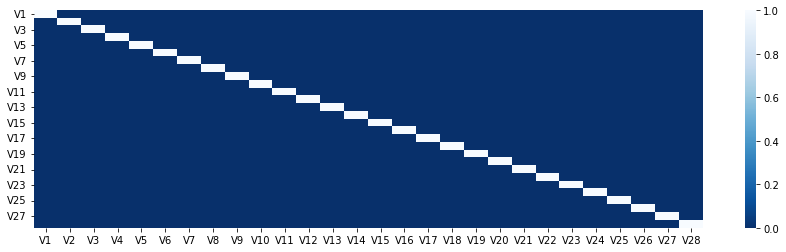

In [6]:
# feature correlation
import seaborn as sns
plt.figure(figsize=(15,4))
f_cor = df_hist.corr()
sns.heatmap(f_cor, cmap="Blues_r")

In [7]:
# Plot the balance of class labels
df_base = df.copy()

print('0 = nominal transactions, 1 = fraud')
value_counts = df_base['Class'].value_counts()
print(value_counts)


contamination_rate = value_counts[1]/value_counts[0]
print(contamination_rate)

0 = nominal transactions, 1 = fraud
0    284315
1       492
Name: Class, dtype: int64
0.0017304750013189597


Text(0.5, 0.98, 'Transaction Amount over Time split by Class')

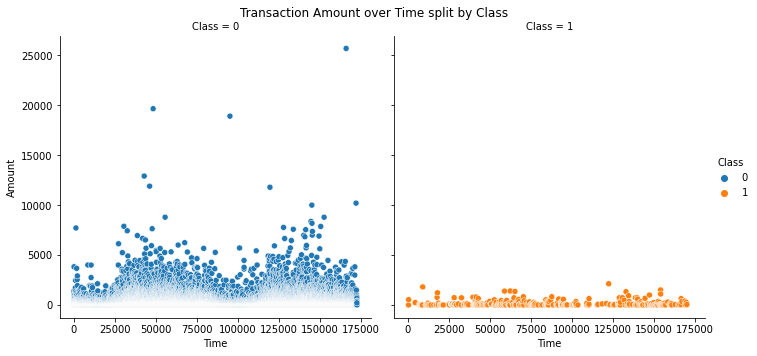

In [8]:
# Plot time against amount
x = df_base['Time']
y = df_base['Amount']
rp = sns.relplot(data=df_base, x=x, y=y, col="Class", kind="scatter", hue="Class")
rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Transaction Amount over Time split by Class')

**Data Preprocessing**

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Separate the classes from the train set
df_classes = df_base['Class']
df_train = df_base.drop(['Class'], axis=1)

# split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(df_train, df_classes, test_size=0.30, random_state=42)

In [14]:
# train the model on the nominal train set
model_isf = IsolationForest().fit(X_train)

Isolation Forest (baseline) model
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     81984
           1       0.85      0.03      0.06      3459

    accuracy                           0.96     85443
   macro avg       0.91      0.52      0.52     85443
weighted avg       0.96      0.96      0.94     85443

f1_score: 52.22%


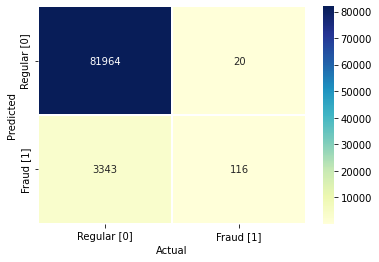

In [17]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset
    df_pred_test = X_test.copy()
    #df_pred_test['Class'] = y_test
    df_pred_test['Pred'] = model.predict(X_test)
    if map_labels:
        df_pred_test['Pred'] = df_pred_test['Pred'].map({1: 0, -1: 1})
    #df_pred_test['Outlier_Score'] = model.decision_function(X_test)

    # measure performance
    #y_true = df_pred_test['Class']
    x_pred = df_pred_test['Pred'] 
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Regular [0]', 'Fraud [1]'], 
                yticklabels=['Regular [0]', 'Fraud [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(x_pred, y_true))
    
    model_score = score(x_pred, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

model_name = 'Isolation Forest (baseline)'
print(f'{model_name} model')

map_labels = True
model_score = measure_performance(model_isf, X_test, y_test, map_labels)

performance_df = pd.DataFrame().append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

**Isolation Forest Hyperttuning**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have v

Best: [0.00090955 0.00091288 0.00092948 0.0008526  0.000943   0.0009061 ], using {'bootstrap': True, 'max_features': 10, 'n_estimators': 50}
Isolation Forest (tuned) model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85304
           1       0.37      0.36      0.36       139

    accuracy                           1.00     85443
   macro avg       0.68      0.68      0.68     85443
weighted avg       1.00      1.00      1.00     85443

f1_score: 68.13%


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.906111,0.334278,1.139293,0.112427,True,1,50,"{'bootstrap': True, 'max_features': 1.0, 'n_es...",0.000793,0.000973,0.000963,0.000910,0.000083,4
1,5.059743,0.016935,2.128941,0.018998,True,1,100,"{'bootstrap': True, 'max_features': 1.0, 'n_es...",0.000863,0.000903,0.000973,0.000913,0.000046,3
2,1.849065,0.012061,0.809985,0.009974,True,5,50,"{'bootstrap': True, 'max_features': 5, 'n_esti...",0.000873,0.000903,0.001013,0.000929,0.000060,2
3,3.569654,0.037703,1.598012,0.016050,True,5,100,"{'bootstrap': True, 'max_features': 5, 'n_esti...",0.000792,0.000873,0.000893,0.000853,0.000043,6
4,2.072293,0.013413,0.877329,0.009523,True,10,50,"{'bootstrap': True, 'max_features': 10, 'n_est...",0.000963,0.000883,0.000983,0.000943,0.000043,1
5,3.987379,0.016365,1.722294,0.014196,True,10,100,"{'bootstrap': True, 'max_features': 10, 'n_est...",0.000873,0.000903,0.000943,0.000906,0.000029,5


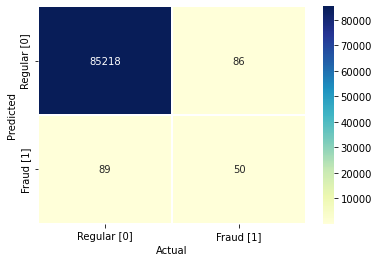

In [18]:
# Define the parameter grid
n_estimators=[50, 100]
max_features=[1.0, 5, 10]
bootstrap=[True]
param_grid = dict(n_estimators=n_estimators, max_features=max_features, bootstrap=bootstrap)

# Build the gridsearch
model_isf = IsolationForest(n_estimators=n_estimators, 
                            max_features=max_features, 
                            contamination=contamination_rate, 
                            bootstrap=False, 
                            n_jobs=-1)

# Define an f1_scorer
f1sc = make_scorer(f1_score, average='macro')

grid = GridSearchCV(estimator=model_isf, param_grid=param_grid, cv = 3, scoring=f1sc)
grid_results = grid.fit(X=X_train, y=y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

# Evaluate model performance
model_name = 'Isolation Forest (tuned)'
print(f'{model_name} model')

best_model = grid_results.best_estimator_
map_labels = True # if True - maps 1 to 0 and -1 to 1 - not required for scikit-learn knn models
model_score = measure_performance(best_model, X_test, y_test, map_labels)
performance_df = performance_df.append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)
results_df